# Convergence & Game Success
Before analyzing the languages learnt by the agent communities, I check to what degree the communities actually agreed on a common language and whether they learnt to play the game succesfully.

### Loading Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import egg.core as core
from egg.core import Callback, Interaction, PrintValidationEvents
from torchvision import models, datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import os.path
from torch.utils.data import Dataset
import sys
import argparse
import math
import psutil
import csv
import json
from scipy.spatial import distance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Computing Average Community Accuracies and Language Convergence Scores from Evaluation Data

In [2]:
# evaluation of language convergence and game accuracy on test set
comm_sizes = [1,2,4]
seeds = [1,2,3,4,5]
# in the case of a single pair, the language convergence is 1 since there is only one message
#convergence_scores = [1]
avg_convergence_scores = []
convergence_scores = []
avg_accuracies = []
accuracies = []

def similarity_measure(message_1, message_2):
    hamming_distance = distance.hamming(message_1, message_2)
    return (1-hamming_distance)

for size in comm_sizes:
    size_conv_scores = []
    size_accs = []
    for seed in seeds:
        seed_avg_pairw_sims = []
        seed_accs = []
        
        # load the respective evaluation data
        eval_data_path = './Data/Evaluation_Data/Comm_Size_'+ str(size) +'/Seed_'+str(seed)+'/evaluation_data.csv'
        with open(eval_data_path, 'r') as eval_data:
            reader = csv.reader(eval_data)
            for i,line in enumerate(reader):
                # skipping i = 0 (the header row)
                if i > 0:
                    seed_accs.append(float(line[3]))
                    messages = []
                    for sender_idx in range(size):
                        message = np.array([int(symbol) for symbol in line[4+sender_idx].split(',')])
                        messages.append(message)
                    # computing the pairwise cosine similarities between all messages
                    pairwise_similarities = []
                    counter = 0
                    for message_1 in messages[counter:]:
                        for message_2 in messages[counter+1:]:
                            pairwise_similarities.append(similarity_measure(message_1[:-1], message_2[:-1]).item())
                        counter+=1
                    # if statement to prevent computing mean of empty list (when size = 1)
                    if size > 1:
                        seed_avg_pairw_sims.append(np.array(pairwise_similarities).mean())
                    elif size == 1:
                        seed_avg_pairw_sims.append(1)
        size_conv_scores.append(np.array(seed_avg_pairw_sims).mean())
        size_accs.append(np.array(seed_accs).mean())
    
    avg_accuracies.append(np.array(size_accs).mean())
    accuracies.append(size_accs)
    # averaging over all the average pairwise similarites of the test dataset and storin as convergence score for plotting
    avg_convergence_scores.append(np.array(size_conv_scores).mean())
    convergence_scores.append(size_conv_scores)

In [6]:
print('Convergence Scores of all Seeds:')
print(convergence_scores)
print('Accuracies of all Seeds:')
print(accuracies)
print('Avg Convergence Scores of all Sizes:')
print(avg_convergence_scores)
print('Avg Accuracies of all Sizes:')
print(avg_accuracies)

Convergence Scores of all Seeds:
[[1.0, 1.0, 1.0, 1.0, 1.0], [0.41692799999999997, 0.05441199999999999, 0.3771880000000001, 0.18587, 0.19354199999999996], [0.129448, 0.17345866666666668, 0.26265999999999995, 0.3855236666666667, 0.29656899999999997]]
Accuracies of all Seeds:
[[0.93856, 0.97503, 0.92774, 0.96633, 0.89976], [0.9125, 0.897315, 0.9189275, 0.906615, 0.9286025], [0.90751375, 0.89303625, 0.898134375, 0.896629375, 0.919498125]]
Avg Convergence Scores of all Sizes:
[1.0, 0.245588, 0.24953186666666666]
Avg Accuracies of all Sizes:
[0.941484, 0.9127919999999999, 0.9029623749999999]


### Plotting

Text(0, 0.5, 'Accuracy')

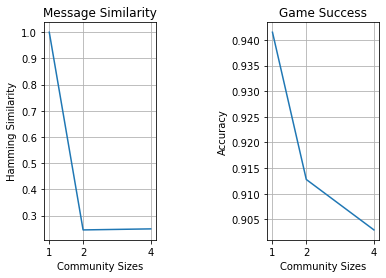

In [4]:
fig, axs = plt.subplots(1,2, sharex = True)
#fig.tight_layout()
plt.subplots_adjust(wspace = 1)
axs[0].plot(comm_sizes, avg_convergence_scores)
axs[0].grid(True)
axs[0].set_title('Message Similarity')
axs[0].set_xticks(comm_sizes)
axs[0].set_xlabel('Community Sizes')
axs[0].set_ylabel('Hamming Similarity')

axs[1].plot(comm_sizes, avg_accuracies)
axs[1].grid(True)
axs[1].set_title('Game Success')
axs[1].set_xlabel('Community Sizes')
axs[1].set_ylabel('Accuracy')
# 0.8915200000000001

### Storing Results

In [8]:
with open('./Data/Results/conv_scores.txt', 'a') as file:
    for i,seed_scores in enumerate(convergence_scores):
        str_seed_scores = str(seed_scores).replace('[', '').replace(']', '')
        file.write(str_seed_scores + ';' + str(avg_convergence_scores[i]) + '\n')

with open('./Data/Results/accuracies.txt', 'a') as file:
    for i,seed_accs in enumerate(accuracies):
        str_seed_accs = str(seed_accs).replace('[', '').replace(']', '')
        file.write(str_seed_accs + ';' + str(avg_accuracies[i]) + '\n')